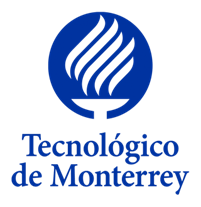

## Computer Vision (Gpo 10)

### Professors: 
* Dr. Gilberto Ochoa Ruiz
* Mtra. Yetnalezi Quintas Ruiz

### Students: 
* Armando Bringas Corpus - A01200230
* Guillermo Alfonso Muñiz Hermosillo - A01793101
* Jorge Luis Arroyo Chavelas - A01793023
* Samantha R Mancias Carrillo - A01196762
* Sofia E Mancias Carrillo - A01196563




# Image Segmentation - Watershed

## Table of Contents
1. [Libraries](#libraries)
2. [Implementation with OpenCV](#opencv)

    a. [Marker-based image segmentation](#opencv_markerbased)

2. [Implementation with skimage](#skimage)
    
    a. [Compact Watershed](#skimage_compactwatershed)
    
    b. [Morphological Watershed Algorithm](#skimage_morphologicalwatershed)

3. [Applications](#applications)

    a. [Magnetic Resonance Imaging (MRI) - Brain Segmentation](#mri)
    
    b. [Cell Nuclei Analysis - Osteosarcoma](#cellnucleianalysis)

## Libraries <a class="anchor" id="libraries" ></a>

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.filters import sobel
from skimage.segmentation import mark_boundaries,watershed, clear_border
from skimage.io import imread
from scipy import ndimage
from skimage import measure, color, io


## Implementation with Open CV <a class="anchor" id="opencv" ></a>

### Marker-based image segmentation <a class="anchor" id="opencv_markerbased" ></a>

In [2]:
def plot_images(img1, img2, img1_title, img2_title):
    plt.figure(figsize=([20, 20]))
    plt.subplot(121),plt.imshow(img1, cmap='gray')
    plt.title(img1_title, size=15), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img2, cmap='gray')
    plt.title(img2_title, size=15), plt.xticks([]), plt.yticks([])
    plt.show()

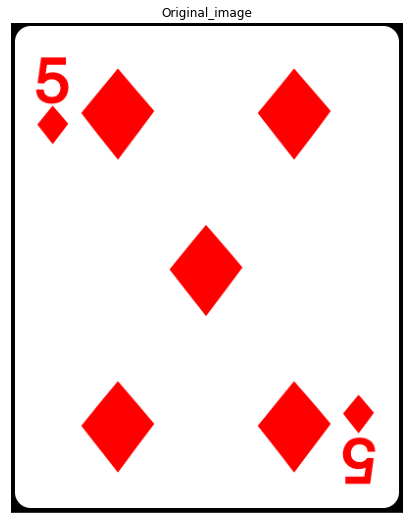

In [3]:
# Load image 
img = cv2.imread('img/card.png')
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=([9, 9]))
plt.imshow(img_RGB), plt.title('Original_image'), plt.xticks([]), plt.yticks([])
plt.show()

Convertimos la imagen importada a escala de grises y realizamos un operación de umbralizado por medio del algoritmo de binarización de Otsu el cual  nos permite dividir la imagen en dos regiones, en negros y blancos.

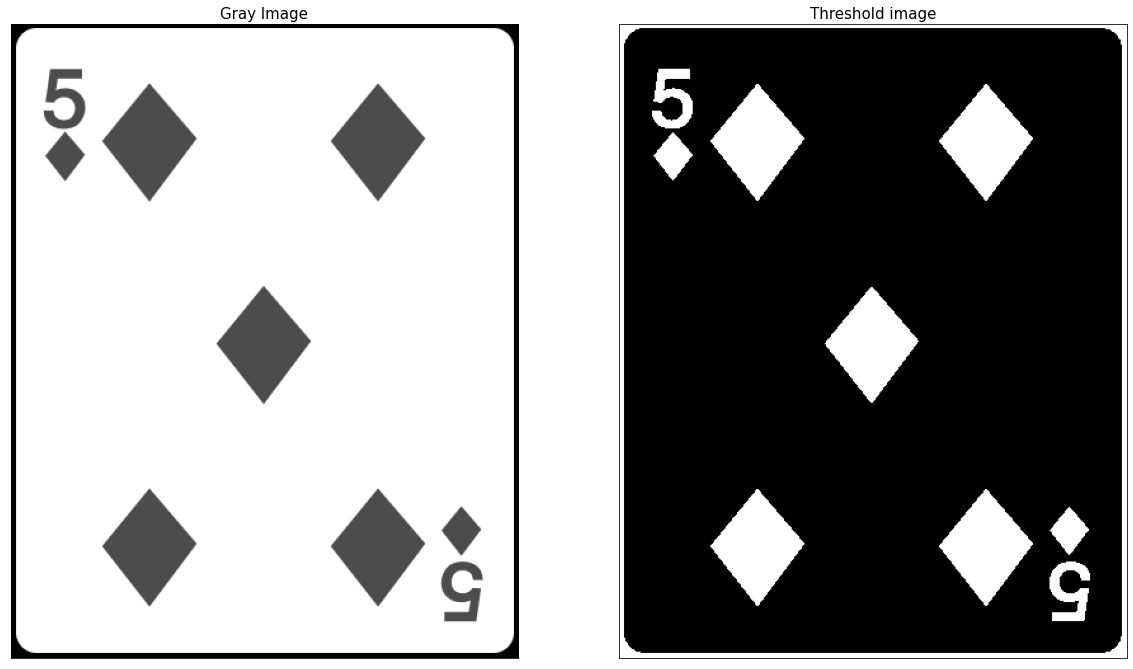

In [4]:
# convert from color to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Divide the image into two regions, blacks and whites
ret, thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plot_images(gray_img, thresh, 'Gray Image', 'Threshold image')


A continuación, es normal que nuestra imagen pueda contener ruido, lo cual puede dificultar el procesamiento posterior por lo que se puede aplicar una transformación morfológica que implica la dilatación o erosión de las regiones blancas de la imagen en varios pasos para eliminar el ruido. Posteriormente, se puede utilizar la operación abierta morfológica, que consiste en erosionar después de de dilatar, para que de esta manera las regiones blancas grandes se expandan y se "tragen" las regiones negras pequeñas, lo cual contribuye a eliminar el ruido. Las regiones negras grandes, que representan objetos reales, permanecen relativamente sin cambios. Se puede utilizar la función cv2.morphologyEx con el argumento cv2.MORPH_OPEN para realizar esta operación.

Posteriormente, se puede dilatar el resultado de la transformación abierta para obtener regiones que probablemente sean el fondo de la imagen. Para la obteción de regiones seguras del primer plano, se puede aplicar una transformación de distancia la cual en términos prácticos, podemos estar más seguros de que un punto es realmente parte del primer plano si está lejos del borde del primer plano-fondo más cercano. Después de aplicar la transformación de distancia, se puede aplicar un umbral para seleccionar las regiones que son seguras para el primer plano.

Las regiones intermedias, que no son seguras ni para el primer plano ni para el fondo, se pueden encontrar restando el primer plano seguro del fondo seguro. Estas regiones son denominadas como regiones inseguras o desconocidas.

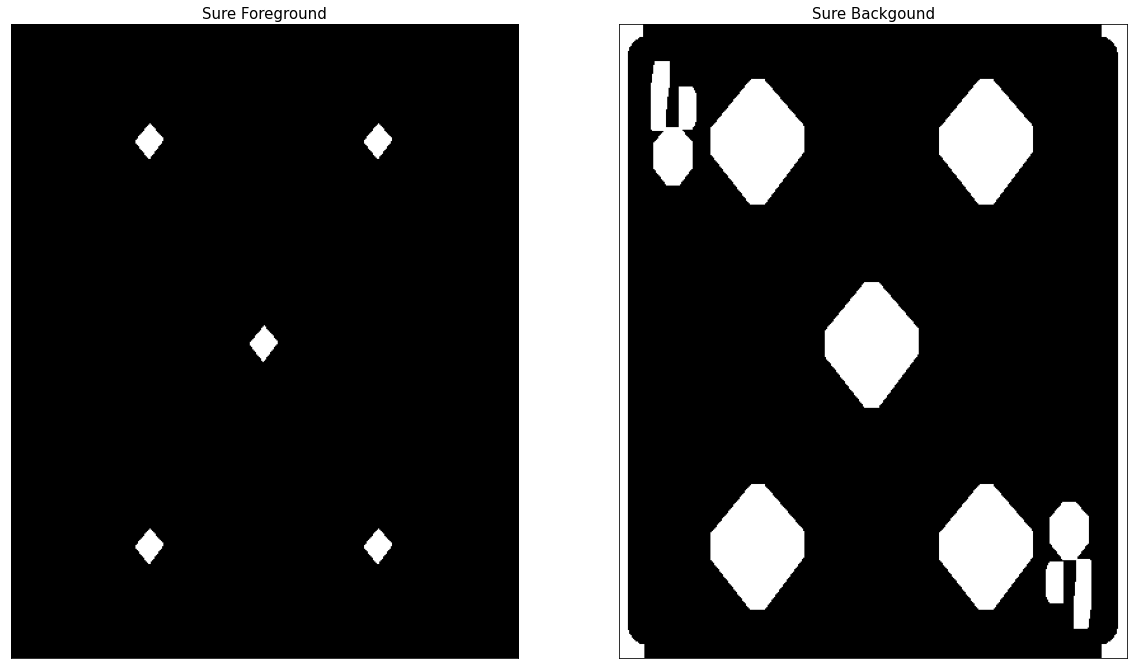

In [5]:
# noise removal
kernel = np.ones((5,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Plot the results
plot_images(sure_fg, sure_bg, 'Sure Foreground', 'Sure Backgound')

Al encontrar las regiones anteriormente descritas, podemos construir nuestras barreras para evitar que el agua se mezcle. Esto se hace con la función connectedComponents que proviene de la teoría de grafos cuando analizamos el algoritmo GrabCut y conceptualizamos una imagen como un conjunto de nodos que están conectados por bordes. Teniendo las áreas seguras de primer plano, algunos de estos nodos se conectarán entre sí, pero otros no. Los nodos desconectados pertenecen a diferentes valles de agua, por lo que debe haber una barrera entre ellos.

Para los marcadores, agregamos 1 a las etiquetas para todas las regiones porque solo queremos que las incógnitas permanezcan en 0.

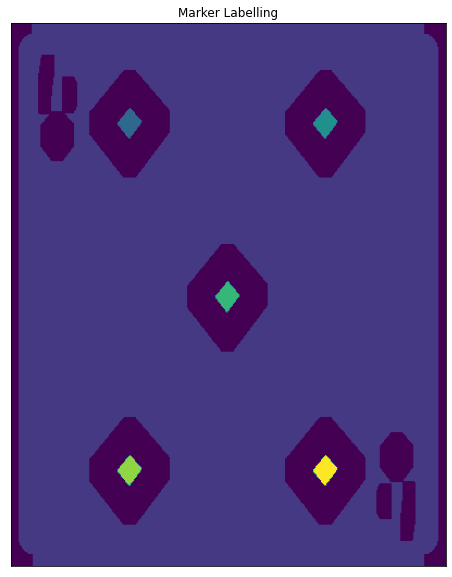

In [6]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

plt.figure(figsize=([10, 10]))
plt.imshow(markers), plt.title('Marker Labelling'), plt.xticks([]), plt.yticks([])
plt.show()


Finalmente ejecutamos el algoritmo de watershed, en cual dejamos que fluya el agua, la función cv2.watershed asigna la etiqueta -1 a los píxeles que son bordes entre componentes. Coloreamos estos bordes de azul en la imagen original y utilizamos la librería matplotlib para visualizar los resultados.

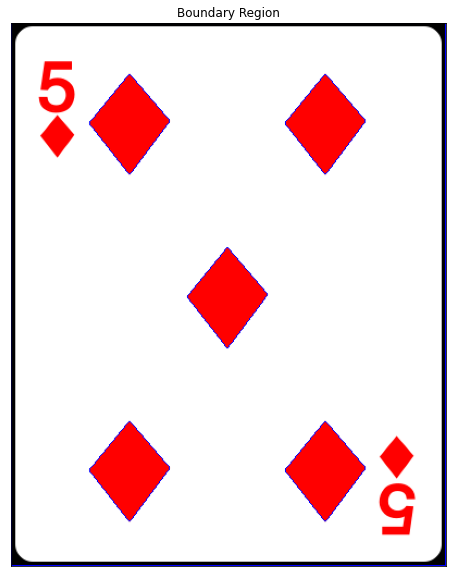

In [7]:
# Apply watershed, boundary region will be marked with -1
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

plt.figure(figsize=([10, 10]))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Boundary Region'), plt.xticks([]), plt.yticks([])
plt.show()

En este caso la implementación funciona de forma adecuada, pero no para todos los elementos de la imagen. Al momento de probar con otras imágenes pudimos darnos cuenta de que no siempre se obtienen resultados satisfactorios, se requiere de hacer un ajuste de los parámetros en las operaciones morfológicas que se realizan. Sin embargo la implementación anteriormente expuesta de de las más conocidas e implementada con la librería Open CV, existen diferentes variaciones para implementar Watershed, a continuación veremos algunas variaciones utilizando diferentes técnicas y las librerías skimage y simpleITK.

## Implementation with skimage <a class="anchor" id="skimage" ></a>

### Compact Watershed <a class="anchor" id="skimage_compactwatershed" ></a>

In [ ]:
# Load image and select every other pixel in each dimension
img = imread('img/Peony-Rose-Flowers.jpg')[::2, ::2, :3]

# Compute gradient of image
gradient = sobel(rgb2gray(img))

# Set up plot
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axs = axs.ravel()

# Setup parameters for Watershed algorithm
markers_list = [50, 50, 200, 200]
compactness_list = [0.01, 0.001, 0.01, 0.001]

# Apply watershed segmentation with different parameters and plot results
for i, (markers, compactness) in enumerate(zip(markers_list, compactness_list)):
    segments_watershed = watershed(gradient, markers=markers, compactness=compactness)
    axs[i].imshow(mark_boundaries(img, segments_watershed))
    axs[i].set_title(f"markers={markers}.compactness={compactness}", size=20)
    axs[i].axis('off')

plt.suptitle('Compact watershed', size=30)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Morphological Watershed Algorithm <a class="anchor" id="skimage_morphologicalwatershed" ></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from skimage.feature import canny
from scipy import ndimage as ndi
from skimage.filters import sobel
from skimage import data
from skimage.color import label2rgb
from skimage.segmentation import watershed


coins = data.coins()
hist = np.histogram(coins, bins=np.arange(0, 256))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.imshow(coins, cmap=plt.cm.gray, interpolation='nearest')
ax1.axis('off')
ax2.plot(hist[1][:-1], hist[0], lw=2)
ax2.set_title('histogram of grey values')

In [ ]:
# Threshold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
ax1.imshow(coins > 100, cmap=plt.cm.gray, interpolation='nearest')
ax1.set_title('coins > 100')
ax1.axis('off')
ax1.set_adjustable('box')
ax2.imshow(coins > 150, cmap=plt.cm.gray, interpolation='nearest')
ax2.set_title('coins > 150')
ax2.axis('off')
ax2.set_adjustable('box')
margins = dict(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)
fig.subplots_adjust(**margins)

In [ ]:
elevation_map = sobel(coins)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(elevation_map, cmap=plt.cm.gray, interpolation='nearest')
ax.axis('off')
ax.set_title('elevation_map')

In [ ]:
markers = np.zeros_like(coins)
markers[coins < 30] = 1
markers[coins > 150] = 2

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(markers, cmap=plt.cm.Spectral, interpolation='nearest')
ax.axis('off')
ax.set_title('markers')


In [ ]:
segmentation = watershed(elevation_map, markers)
fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(segmentation, cmap=plt.cm.gray, interpolation='nearest')
ax.axis('off')
ax.set_title('segmentation')

In [ ]:
segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled_coins, _ = ndi.label(segmentation)
image_label_overlay = label2rgb(labeled_coins, image=coins)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
ax1.imshow(coins, cmap=plt.cm.gray, interpolation='nearest')
ax1.contour(segmentation, [0.5], linewidths=1.2, colors='y')
ax1.axis('off')
ax1.set_adjustable('box')
ax2.imshow(image_label_overlay, interpolation='nearest')
ax2.axis('off')
ax2.set_adjustable('box')

## Applications <a class="anchor" id="applications" ></a>

### Magnetic Resonance Imaging (MRI) - Brain Segmentation <a class="anchor" id="mri" ></a>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import SimpleITK as sitk
from myshow import myshow, myshow3d


# Download data to work on]
%run update_path_to_download_script
from downloaddata import fetch_data as fdata

from ipywidgets import interact, interactive, FloatSlider


In [ ]:
def watershed_otsu_labeling(img,spot_sigma=2, outline_sigma=2, watershed_level=10, show_watershed_edge=True, show_RGB=False):
    blurred_spots = sitk.GradientMagnitudeRecursiveGaussian(img, sigma=spot_sigma)
    blurred_outline = sitk.DiscreteGaussian(img, variance=[outline_sigma, outline_sigma, outline_sigma])
    binary_otsu = sitk.OtsuThreshold(blurred_outline, 0, 1)
    ws = sitk.MorphologicalWatershed(blurred_spots, markWatershedLine=show_watershed_edge, level=watershed_level)
    labels = sitk.Mask(ws, sitk.Cast(binary_otsu, ws.GetPixelID()))
    if show_RGB:
        myshow(sitk.LabelToRGB(labels), title="Watershed Segmentation")
    else:
        myshow(labels, title='Watershed Otsu labeling')

In [ ]:
img = sitk.ReadImage(fdata("cthead1.png"))
myshow(img)

In [ ]:
watershed_otsu_labeling(img,spot_sigma=2, outline_sigma=2, watershed_level=5, show_watershed_edge=True, show_RGB=False)

In [ ]:
watershed_otsu_labeling(img,spot_sigma=2, outline_sigma=2, watershed_level=5, show_watershed_edge=True, show_RGB=True)

In [ ]:
def callback(img, *args, **kwargs):
    watershed_otsu_labeling(img, *args, **kwargs)
    
interact(
    lambda **kwargs: callback(img, **kwargs),
    spot_sigma = FloatSlider(min=.1, max=5, step=.1, value=2),
    outline_sigma = FloatSlider(min=.1, max=5, step=.1, value=2),
    watershed_level = FloatSlider(min=1, max=10, step=.1, value=5),
    show_watershed_edge = True,
    show_RGB = True
)

In [ ]:
img = sitk.ReadImage('img/normal-ct-brain.jpg',  sitk.sitkFloat32)
myshow(img)

In [ ]:
watershed_otsu_labeling(img,spot_sigma=5, outline_sigma=5, watershed_level=5, show_watershed_edge=True, show_RGB=False)

In [ ]:
watershed_otsu_labeling(img,spot_sigma=5, outline_sigma=5, watershed_level=5, show_watershed_edge=True, show_RGB=True)

In [ ]:
def callback(img, *args, **kwargs):
    watershed_otsu_labeling(img, *args, **kwargs)
    
interact(
    lambda **kwargs: callback(img, **kwargs),
    spot_sigma = FloatSlider(min=.1, max=5, step=.1, value=5),
    outline_sigma = FloatSlider(min=.1, max=5, step=.1, value=5),
    watershed_level = FloatSlider(min=1, max=10, step=.1, value=5),
    show_watershed_edge = True,
    show_RGB = True
)

A continuación vemos un caso donde por más que se intento ajustar los parámetros los resultados fueron de sobre-segmentación, inferimos que se puede deber por la resolución de la imagén y que se necesita trabajar más la parte de preprocesamiento o incluso probar con algún otro algoritmo de segmentación. Sin embargo, decidimos dejar el ejemplo ya que nos pareció visualmente llamativo.

In [ ]:
img = sitk.ReadImage('img/MRI_2.png', sitk.sitkFloat32)
myshow(img)

In [ ]:
watershed_otsu_labeling(img,spot_sigma=2, outline_sigma=2, watershed_level=3.7, show_watershed_edge=False, show_RGB=True)

In [ ]:
def callback(img, *args, **kwargs):
    watershed_otsu_labeling(img, *args, **kwargs)
    
interact(
    lambda **kwargs: callback(img, **kwargs),
    spot_sigma = FloatSlider(min=.1, max=5, step=.1, value=2),
    outline_sigma = FloatSlider(min=.1, max=5, step=.1, value=2),
    watershed_level = FloatSlider(min=1, max=10, step=.1, value=3.7),
    show_watershed_edge = False,
    show_RGB = True
)

### Cell Nuclei Analysis - Osteosarcoma <a class="anchor" id="cellnucleianalysis" ></a>

In [ ]:
def plot_img(img, operation, cmap="gray"):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
    ax.imshow(img, cmap=cmap)
    ax.set_title(operation)
    ax.axis('off')

    plt.show()

In [ ]:
# Empezamos leyendo nuestra imagen de microscopio en formato tif
orig_img = cv2.imread("img/cell1.jpg")
plot_img(orig_img, "Imagen Original")

Para poder llevar a cabo la segmentacion de estas imagenes, necesitamos extraer el azul ya que estas imagenes fueron obtenidas con una tinta azul especial para detectar las celulas cancerigenas.

In [ ]:
blue_img = orig_img[:,:,0]
plot_img(blue_img, "Imagen en canal Azul")

Una vez extraido el color azul es necesario establecer un umbral de intensidad.

Para este ejemplo, usaremos el metodo de OTSU para extraer una imagen binaria, es decir todos los pixeles umbralados seran puestos en 255 o 0


In [ ]:
ret1, thresh = cv2.threshold(blue_img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plot_img(thresh, "Imagen con umbralado OTSU")

Un paso improtante despues de aplicar el umbralado y contar con una imagen binaria es el realizar la operacion morfologica de apertura.

Si recordamos de lo aprendido en el curso, la operacion de apertura es aplicar a una imagen erocionada (eliminar pixeles en los limites de objetos) una dilatacion (agregar pixeles a los limites de un objeto) usando el mismo tamaño de kernel para ambas operaciones. 
Usando la funcion clear border en la imagen de apertura, eliminamos aquellos objetos que esten tocando el borde de la imagen.

In [ ]:
kernel = np.ones((3,3), np.uint8)
opening_img = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 5)

opening_img = clear_border(opening_img) 


plot_img(opening_img, "Imagen con apertura y bordes eliminados")

Comenzamos pues identificando el fondo de la imagen (background). Al dilatar los pixeles varias veces se incrementa los limites de la imagen con respecto al fondo. De esta manera lo que quede despues de la dicha operacion seguramente pertenece al fondo(background)

El area entre el fondo y el frente se conoce como el area ambigua o desconocida. El algoritmo de Watershed debe de ser capaz de encontrar esta area por nosotros.

Lo que se muestre en fondo negro es seguramente el fondo de la imagen, lo blanco no estamos seguros aun a que clase pertenece.

In [ ]:
sure_bg = cv2.dilate(opening_img,kernel,iterations=10)

plot_img(sure_bg, "Fondo de la imagen")

El siguiente paso es  encontrar el primer plano de nuestra imagen, para hacer esto es necesario encontrar para un pixel dado cual es la distancia mas corta para el mas cercano a 0 (pixel negro o el fondo de la imagen). A esto se le conoce como calcular la distancia euclidiana de una imagen.

Las areas cercanas al fondo de la imagen tendran un valor de distancia bajo y las mas lejanas un valor alto. Es por esto que necesitamos adaptar el resultado de la distancia para poder tener un umbral de intensidad que permita la correcta separacion de los componentes de la imagen, es decir, es necesario encontrar el umbral ideal. 
Para este ejemplo decidimos comenzar  con la mitad del valor maximo obtenido.

In [ ]:

dist_transform = cv2.distanceTransform(opening_img,cv2.DIST_L2,5)
ret2, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)

plot_img(sure_fg, "Primer plano de la Imagen")

Ahora nos queda solamente definir nuestra area desconocida, la cual el algoritmo de Watershed se encargara de llenar.
Es decir, tenemos que encontrar el area que no estamos seguros si es parte del fondo o del primer plano de la imagen.

Esta area la calculamos con una operacion de extraccion del primer plano y el fondo.

In [ ]:
sure_fg = np.uint8(sure_fg)
unknown_img = cv2.subtract(sure_bg,sure_fg)

plot_img(unknown_img, "Imagen del area desconocida")

Es necesario crear marcadores y etiquetas para las regiones dentro de la imagen
Las areas que tenemos certeza de a donde pertenecen deben ser etiquetadas con valores numericos positivos.
Las regiones desconocidas con 0.

Un problema al usar la libreria *connectedComponents* es que a todos los pixeles de fondo se les asigna el valor de 0. Eso podria causar que nuestro algoritmo de watershed considere estas regiones como desconocidas.
Para evitarlo, agregamos un valor positivo a todas las etiquetas para asegurarnos que las regiones que son seguramente de fondo no son 0.

In [ ]:
ret3, markers = cv2.connectedComponents(sure_fg)

markers = markers+10

# Finalmente marcamos las regiones desconocidas con 0.
markers[unknown_img==255] = 0
plot_img(markers, "Imagen de marcadores", "jet")

Una vez que contamos con marcadores correctos, podemos aplicar el algoritmo de watershed usando la imagen original y nuestros marcadores obtenidos.

OpenCV asigna los limites que rodean a los segmentos de la imagen con valor de -1 despues de aplicado el algoritmo, por lo que podemos colorear estos para identificarlos al mostrar la imagen de nuevo.

In [ ]:
markers = cv2.watershed(orig_img,markers)

orig_img[markers == -1] = [255,255,0]  

watershed_img = color.label2rgb(markers, bg_label=0)

plot_img(watershed_img, "Imagen con el algoritmo Watershed")
plot_img(orig_img, "Etiquetado de bordes en la imagen original")